In [1]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install keras
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.Collecting optuna
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/a0/8c/f72c6bc61b3c71149af95cd91e16149ea5b5aeae99e6d197f80e79a1035a/optuna-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/11/00/46a4f66ad54c661350a1cd5daae4b4ab2232486c55635ee12ff12958b03f/alembic-1.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for cmaes>=0.9.1 from https://files.pythonhosted.org/packages/f7/46/7d9544d453346f6c0c405916c95fdb653491ea2e9976cabb810ba2fe8cd4/cmaes-0.10.0-py3-none-any.whl.metadata
     -------------------------------------- 78.7/78.7 kB 400.2 kB/s eta 0:00:00
   -------------------------------------- 390.6/390.6 kB 716.3 kB/s eta 0:00:00
   ---------------------------------------- 224.5/224.5 kB 1.5 MB/s eta 0:00:00



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [12]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [5]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [6]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
voo_data = yf.download("VOO", period = '5y')

data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
#SIMPLE 80:20 SPLIT

split_index = int(len(data) * 0.8)
train_df = data[:split_index]
val_df = data[split_index:]

In [7]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [8]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=1000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=1000)

    logger.info('Training is complete')

    

    def evalModel():
        ppo_rewards = []
        obs1 = val_env1.reset()

        while True:
            action, _ = ppo_agent.predict(obs1)
            logger.info(f'PPO Took action {action} in state {obs1}')
            obs, reward, done, info = val_env1.step(action)
            ppo_rewards.append(reward)

            if done:
                break

        print('PPO average validation reward: ', np.mean(ppo_rewards))

        a2c_rewards = []
        obs2 = val_env1.reset()

        while True:
            action, _ = a2c_agent.predict(obs2)
            obs, reward, done, info = val_env1.step(action)
            a2c_rewards.append(reward)

            if done:
                break

        print('PPO average validation reward: ', np.mean(a2c_rewards))

        if np.mean(ppo_rewards) > np.mean(a2c_rewards):
            agent = ppo_agent
            action, _ = agent.predict(obs2)
            print('Agent chosen is: PPO')
        else:
            agent = a2c_agent
            action, _ = agent.predict(obs)
            print('Agent chosen is: A2C')




        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()
    evalModel()

    
n_cpu = 4
def optimizePPO(trial):
    return {
        'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma' : trial.suggest_log_uniform('gamma', 0.9, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        'cliprange': trial.suggest_uniform('cliprange', 0.1, 0.4),
        'noptepochs' : int(trial.suggest_loguniform('noptepochs', 1, 48)),
        'lam': trial.suggest_uniform('lam', 0.8, 1.)
    }



def optimize_agent(trial):
    model_params = optimizePPO(trial)
    env = 
    model = ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward)

    return -1 * last_reward


    
            

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\l

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 98       |
| time/              |          |
|    fps             | 2140     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1111     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.482    |
|    value_loss         | 3.

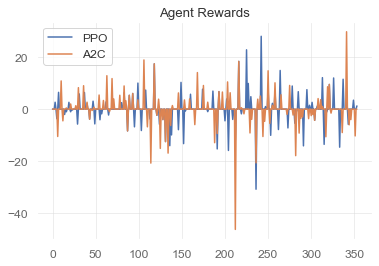

In [9]:
ModelCreation()

In [32]:
window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
        'stocks-v0',
        df = train_df,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

val_env1 = gym.make(
    'stocks-v0',
    df = val_df_1,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)




val_env2 = gym.make(
    'stocks-v0',
    df = val_df_2,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



val_env3 = gym.make(
    'stocks-v0',
    df = val_df_3,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])


n_cpu = 4

def optimizePPO(trial):
    return {
        'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        #'cliprange': trial.suggest_uniform('cliprange', 0.1, 0.4),
        #'noptepochs' : int(trial.suggest_loguniform('noptepochs', 1, 48)),
        'gae_lambda': trial.suggest_uniform('lam', 0.8, 1.)
    }

n_steps = 0

def optimize_agent(trial):
    model_params = optimizePPO(trial)
    env = env1
    model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward

    

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [34]:
study = optuna.create_study()
study.optimize(optimize_agent, n_trials = 5)



[I 2023-07-28 13:39:22,875] A new study created in memory with name: no-name-d78a7a52-82d6-470d-a4cd-51c3159b159b
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\1689927676.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\1689927676.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\1689927676.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 182      |
| time/              |          |
|    fps             | 2239     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 923      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 719           |
|    ep_rew_mean          | 119           |
| time/                   |               |
|    fps                  | 1530          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1846          |
| train/                  |               |
|    approx_kl            | 0.00025959912 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

[I 2023-07-28 13:46:05,891] Trial 0 finished with value: -2869.190673828125 and parameters: {'n_steps': 923.5411888337701, 'gamma': 0.9484604122005873, 'learning_rate': 1.817547314111267e-05, 'ent_coef': 0.0002313771231886473, 'lam': 0.9783835977732578}. Best is trial 0 with value: -2869.190673828125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2197 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 160  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 160`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=160 and n_envs=1)
  warnings.warn(


-------------------------------------------
| time/                   |               |
|    fps                  | 1407          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 320           |
| train/                  |               |
|    approx_kl            | 0.00026215674 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.00248       |
|    learning_rate        | 5.95e-05      |
|    loss                 | 6.81          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000396     |
|    value_loss           | 8.7           |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 1261           |
|    iterations           | 3              |
|    time_elapsed         | 

[I 2023-07-28 13:52:48,210] Trial 1 finished with value: -4296.12890625 and parameters: {'n_steps': 160.81955899706836, 'gamma': 0.9544757874639662, 'learning_rate': 5.953086914504536e-05, 'ent_coef': 0.0003540069493458941, 'lam': 0.8320519503178792}. Best is trial 1 with value: -4296.12890625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2245 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 327  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 327`, after every 5 untruncated mini-batches, there will be a truncated mini-batch of size 7
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=327 and n_envs=1)
  warnings.warn(


---------------------------------------
| time/                   |           |
|    fps                  | 1463      |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 654       |
| train/                  |           |
|    approx_kl            | 23.517958 |
|    clip_fraction        | 0.983     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0116   |
|    explained_variance   | 0.0048    |
|    learning_rate        | 0.134     |
|    loss                 | 3.49      |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.268     |
|    value_loss           | 11.6      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 31.6      |
| time/                   |           |
|    fps                  | 1313      |
|    iterations           | 3         |


[I 2023-07-28 13:59:10,072] Trial 2 finished with value: -0.0 and parameters: {'n_steps': 327.957776943976, 'gamma': 0.9021210714282458, 'learning_rate': 0.13367428095798292, 'ent_coef': 0.012536075441621327, 'lam': 0.9415660761047107}. Best is trial 1 with value: -4296.12890625.
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1473`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 1
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1473 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 73.8     |
| time/              |          |
|    fps             | 2304     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1473     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 38.2      |
| time/                   |           |
|    fps                  | 1565      |
|    iterations           | 2         |
|    time_elapsed         | 1         |
|    total_timesteps      | 2946      |
| train/                  |           |
|    approx_kl            | 17.901672 |
|    clip_fraction        | 0.983     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0261   |
|    e

[I 2023-07-28 14:05:29,391] Trial 3 finished with value: -0.0 and parameters: {'n_steps': 1473.6187218489654, 'gamma': 0.9804584426151279, 'learning_rate': 0.05681352302370432, 'ent_coef': 6.291580917603856e-06, 'lam': 0.9626546087692742}. Best is trial 1 with value: -4296.12890625.
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 644`, after every 10 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=644 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2265 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 644  |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 96.5      |
| time/                   |           |
|    fps                  | 1519      |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 1288      |
| train/                  |           |
|    approx_kl            | 103.80997 |
|    clip_fraction        | 0.991     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0063   |
|    explained_variance   | 0.00336   |
|    learning_rate        | 0.638     |
|    loss                 | 14.9      |
|    n_updates  

[I 2023-07-28 14:11:59,030] Trial 4 finished with value: -0.0 and parameters: {'n_steps': 644.2604071234576, 'gamma': 0.9070278272241892, 'learning_rate': 0.6375383054532748, 'ent_coef': 0.0004978928768570623, 'lam': 0.9298023032602438}. Best is trial 1 with value: -4296.12890625.


In [35]:
study.best_params

{'n_steps': 160.81955899706836,
 'gamma': 0.9544757874639662,
 'learning_rate': 5.953086914504536e-05,
 'ent_coef': 0.0003540069493458941,
 'lam': 0.8320519503178792}

In [17]:
plt.figure(figsize=(16, 6))
for env in envs:
    env.render()
plt.show()

NameError: name 'envs' is not defined

<Figure size 1152x432 with 0 Axes>

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'